In [1]:
from sympy import *
from sympy import init_printing
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

init_printing(use_unicode=False, wrap_line=False, no_global=True)

In [2]:
P, R, T, v, b, a, alpha, rho = symbols("P R T v b a alpha rho")

In [3]:
P = R*T/(v - b) - a*alpha/(v*(v + b) + b*(v - b))

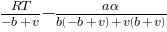

In [4]:
P

In [5]:
M, k = symbols("M xi")

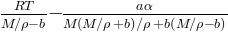

In [6]:
P.subs(v, M/rho)

In [7]:
P_r, rho_r, T_r = symbols("P_r rho_r T_r")
P_c, rho_c, T_c = symbols("P_c rho_c T_c")
omega_a, omega_b = symbols("Omega_a Omega_b")
Z_c = symbols("Z_c")

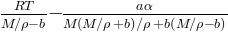

In [8]:
P1 = P.subs(v, M/rho)
P1

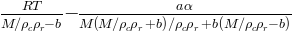

In [9]:
P2 = P1.subs(rho, rho_c * rho_r)
P2

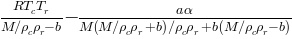

In [10]:
P3 = P2.subs(T, T_c * T_r)
P3

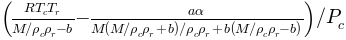

In [11]:
P4 = P3/P_c
P4

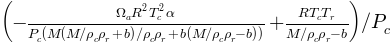

In [12]:
P5 = P4.subs(a, omega_a*(R**2)*(T_c**2)/P_c)
P5

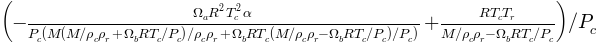

In [13]:
P6 = P5.subs(b, omega_b*R*T_c/P_c)
P6

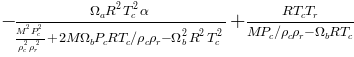

In [14]:
P7 = expand(P6)
P7

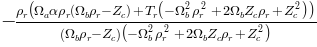

In [15]:
P8 = P7.subs(T_c, P_c * M / (Z_c * rho_c * R))
P_r = simplify(P8)
P_r

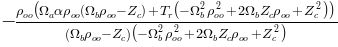

In [16]:
rho_oo = symbols("rho_oo")
P_oo = P_r.subs(rho_r, rho_oo)
P_oo

In [17]:
integrand = expand((P_r - P_oo)/(rho_r ** 2))

In [18]:
def calculate_helmholtz_excess(
    rho_value,     
    reduced_temperature, 
    rho_inf, 
    eos
    ):
    # Defining symbols
    R, T, v, b, a, alpha, rho = symbols("R T v b a alpha rho")
    M, k = symbols("M xi")
    P_r, rho_r, T_r = symbols("P_r rho_r T_r")
    P_c, rho_c, T_c = symbols("P_c rho_c T_c")
    omega_a, omega_b = symbols("Omega_a Omega_b")
    Z_c = symbols("Z_c")
    rho_oo = symbols("rho_oo")
    
    P1 = eos.pressure.subs(v, M/rho)
    P2 = P1.subs(rho, rho_c * rho_r)
    P3 = P2.subs(T, T_c * T_r)
    P4 = P3/P_c
    P5 = P4.subs(a, omega_a*(R**2)*(T_c**2)/P_c)
    P6 = P5.subs(b, omega_b*R*T_c/P_c)
    P7 = expand(P6)
    P8 = P7.subs(T_c, P_c * M / (Z_c * rho_c * R)) 
    
    P_r = simplify(P8)    
    P_oo = P_r.subs(rho_r, rho_oo)    
    integrand = ((P_r - P_oo)/(rho_r ** 2))

    integrand = integrand.subs(omega_a, eos.omega_a)
    integrand = integrand.subs(omega_b, eos.omega_b)
    integrand = integrand.subs(Z_c, eos.critical_z_factor)
    integrand = integrand.subs(T_r, reduced_temperature)
    integrand = integrand.subs(rho_oo, rho_inf)
    
    func = lambdify(rho_r, integrand)
    y, err = integrate.quad(func, rho_inf, rho_value)
    return rho_value * y

In [19]:
# Defining symbols
P, R, T, v, b, a, alpha, rho = symbols("P R T v b a alpha rho")
def find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type):
    coef_a = (3.0 * p2 - (p1 ** 2)) / 3.0        
    coef_b = (2.0 * (p1 ** 3) - 9.0 * p1 * p2 + 27.0 * p3) / 27.0        
    delta = 0.25 * (coef_b ** 2) + (coef_a ** 3) / 27.0     

    if delta > 0.0:
        # 1 real root, 2 imaginary                 
        const_A =  cbrt(-0.5 * coef_b + sqrt(delta)) 
        const_B =  cbrt(-0.5 * coef_b - sqrt(delta))

        correct_root = const_A + const_B - p1 / 3.0 
    else:
        # 3 real roots
        phi = acos(-0.5 * coef_b / sqrt(-(coef_a ** 3) / 27.0))
        root_1 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0) - p1 / 3.0
        root_2 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 2.0 * np.pi / 3.0) - p1 / 3.0
        root_3 = 2.0 * sqrt(-coef_a / 3.0) * cos(phi / 3.0 + 4.0 * np.pi / 3.0) - p1 / 3.0

        smallest_root = min(min(root_1,root_2), root_3)
        largest_root = max(max(root_1,root_2), root_3)

        if fluid_type is 'liquid':        
            correct_root = smallest_root
        else:
            assert fluid_type is 'vapor', 'Wrong fluid type! ' + fluid_type
            correct_root = largest_root
    
    assert correct_root > 0.0, fluid_type + ' Z-factor < 0.0! Delta is %f, %f' % (delta, correct_root)
    
    return correct_root

GAS_CONST = 8.314

class EquationOfState(object):
    def __init__(
        self,
        critical_pressure, 
        critical_temperature,
        acentric_factor,
        molar_mass
    ):       
        self.critical_pressure = critical_pressure
        self.critical_temperature = critical_temperature
        self.acentric_factor = acentric_factor
        self.molar_mass = molar_mass
        
        
    def calculate_pressure_and_densities(self, temperature):
        
        def func(x):            
            pressure = x
            Z_V = eos.calculate_eos_roots(pressure, temperature, 'vapor')
            Z_L = eos.calculate_eos_roots(pressure, temperature, 'liquid')
        
            f_V = eos.calculate_fugacity(pressure, temperature, Z_V)
            f_L = eos.calculate_fugacity(pressure, temperature, Z_L)
            
            return f_V - f_L
            
        from scipy.optimize import newton
        
        pressure = newton(func=func, x0=1.0e5)
        
        Z_V = eos.calculate_eos_roots(pressure, temperature, 'vapor')
        Z_L = eos.calculate_eos_roots(pressure, temperature, 'liquid')
        
        rho_V = pressure * self.molar_mass / (Z_V * GAS_CONST * temperature)
        rho_L = pressure * self.molar_mass / (Z_L * GAS_CONST * temperature)
        
        return pressure, rho_V, rho_L
    
    
class PengRobinsonEos(EquationOfState):
    def __init__(
        self,
        critical_pressure, 
        critical_temperature,
        acentric_factor,
        molar_mass
    ):
        self.omega_a = 0.45724
        self.omega_b = 0.07780
        self.critical_z_factor = 0.3074
        self.pressure = R * T / (v - b) - a*alpha / (v*(v + b) + b*(v - b))
        
        EquationOfState.__init__(self, critical_pressure, critical_temperature, acentric_factor, molar_mass)

    
    def alpha_function(self, reduced_temperature):
        omega = self.acentric_factor
        
        if omega < 0.49:
            m = 0.37464 + 1.54226 * omega - 0.26992 * (omega ** 2)
        else:
            m = 0.379642 + 1.48503 * omega - 0.164423 * (omega ** 2) + 0.016667 * (omega ** 3)
        
        return (1.0 + m * (1.0 - sqrt(reduced_temperature))) ** 2
    
    
    def calculate_fugacity(
        self,
        pressure,
        temperature,
        z_factor
    ):
        P = pressure
        T = temperature
        Z = z_factor
        
        Pr = P / self.critical_pressure
        Tr = T / self.critical_temperature
        
        aa = self.alpha_function(Tr)
        
        A = aa * self.omega_a * Pr / (Tr ** 2)
        B = self.omega_b * Pr / Tr
        
        SQRT_2 = sqrt(2.0)        
        ln_f = (Z - 1.0) - log( Z - B ) - (A / (2.0 * SQRT_2 * B)) \
             * log( (Z + (1.0 + SQRT_2)*B)/(Z + (1.0 - SQRT_2)*B) )
        return P * exp(ln_f)
        
        
    def calculate_eos_roots(self, pressure, temperature, fluid_type):
        P = pressure
        T = temperature

        Pr = P / self.critical_pressure
        Tr = T / self.critical_temperature
        
        aa = self.alpha_function(Tr)
        
        A = aa * self.omega_a * Pr / (Tr ** 2)
        B = self.omega_b * Pr / Tr      
        
        p0 = 1.0
        p1 = - (1.0 - B)
        p2 = A - 3.0 * (B ** 2) - 2.0 * B
        p3 = -(A * B - B ** 2 - B ** 3)     

        return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)       
        
        
class VanDerWaalsEos(EquationOfState):
    def __init__(
        self,
        critical_pressure, 
        critical_temperature,
        acentric_factor,
        molar_mass
    ):
        self.omega_a = 27.0/64.0
        self.omega_b = 1.0/8.0
        self.critical_z_factor = 3.0/8.0
        self.pressure = R * T / (v - b) - a / (v**2)
       
        EquationOfState.__init__(self, critical_pressure, critical_temperature, acentric_factor, molar_mass)
        
    def calculate_fugacity(
        self,
        pressure,
        temperature,
        z_factor
    ):
        P = pressure
        T = temperature
        Z = z_factor
        Pr = P / self.critical_pressure
        Tr = T / self.critical_temperature
        
        A = self.omega_a * Pr / (Tr ** 2)
        B = self.omega_b * Pr / Tr
        
        ln_f = B / (Z - B) - log(Z - B) - 2.0 * A / Z
        return P * exp(ln_f)
    
    
    def calculate_eos_roots(self, pressure, temperature, fluid_type):
        P = pressure
        T = temperature

        Pr = P / self.critical_pressure
        Tr = T / self.critical_temperature
        
        A = self.omega_a * Pr / (Tr ** 2)
        B = self.omega_b * Pr / Tr
        
        p0 = 1.0
        p1 = - (B + 1.0)
        p2 = A
        p3 = - A * B   
        
        return find_correct_root_of_cubic_eos(p0, p1, p2, p3, fluid_type)    
    
    



In [20]:
temperature = 303.15
#pressure = 500.0 * 6894.75729
pressure = 1.0 * 1.0e5

# n-Butane properties
critical_pressure = 6894.75729 * 550.7
critical_temperature = (5.0 / 9.0) * 765.3 # [K]
acentric_factor = 0.192800 # [-]
molar_mass = 58.12 * 0.001 # [kg/mol]

eos = VanDerWaalsEos(critical_pressure, critical_temperature, acentric_factor, molar_mass)
Zfactor = eos.calculate_eos_roots(pressure, temperature, 'vapor')
print Zfactor
print eos.calculate_fugacity(pressure, temperature, Zfactor)


print 'newton results'


pressure, rho_V, rho_L = eos.calculate_pressure_and_densities(temperature)
Z_V = eos.calculate_eos_roots(pressure, temperature, 'vapor')
Z_L = eos.calculate_eos_roots(pressure, temperature, 'liquid')
f_V = eos.calculate_fugacity(pressure, temperature, Z_V)
f_L = eos.calculate_fugacity(pressure, temperature, Z_L)

print f_V, f_L, rho_V, rho_L, pressure

0.982476817228185
98277.1196134455
newton results
714812.851555774 714812.851555785 23.2593689522383 352.245583099088 835569.339164810


# Step by step

1. Given the temperature and an Equation of State
2. Calculate the pressure and the densities

In [22]:
# n-Butane properties
critical_pressure = 6894.75729 * 550.7
critical_temperature = (5.0 / 9.0) * 765.3 # [K]
acentric_factor = 0.192800 # [-]
molar_mass = 58.12 * 0.001 # [kg/mol]

eos = VanDerWaalsEos(critical_pressure, critical_temperature, acentric_factor, molar_mass)

reduced_temperatures = np.linspace(0.4, 0.5, num=5)
#temperature = 303.15
for reduced_temperature in reduced_temperatures:
    temperature = reduced_temperature * critical_temperature
    
    pressure, rho_V, rho_L = eos.calculate_pressure_and_densities(temperature)

    rho_c = eos.critical_pressure * eos.molar_mass / (eos.critical_z_factor * GAS_CONST * eos.critical_temperature)
    rho_inf = rho_L / rho_c 
    
    print reduced_temperature, rho_inf
    
    reduced_densities = np.linspace(0.01, 2.5, num=20)
    psi_vec = []
    for rho in reduced_densities:
        psi = calculate_helmholtz_excess(
            rho_value=rho, 
            reduced_temperature=reduced_temperature, 
            rho_inf=rho_inf,
            eos=eos
            )
        psi_vec.append(psi)
    psi_vec = np.array(psi_vec)

    plt.plot(reduced_densities, psi_vec, marker='o')


ax = plt.gca()
ax.grid(True)
plt.show()


0.4 2.58793748432490
0.425 2.55695590908282
0.45 2.52509676795955
0.475 2.49229809695853
0.5 2.45849200035004


In [23]:
# n-Butane properties
critical_pressure = 6894.75729 * 550.7
critical_temperature = (5.0 / 9.0) * 765.3 # [K]
acentric_factor = 0.192800 # [-]
molar_mass = 58.12 * 0.001 # [kg/mol]

eos = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, molar_mass)

reduced_temperatures = np.linspace(0.8, 0.8, num=1)
#temperature = 303.15
for reduced_temperature in reduced_temperatures:
    temperature = reduced_temperature * critical_temperature    
    pressure, rho_V, rho_L = eos.calculate_pressure_and_densities(temperature)

    rho_c = eos.critical_pressure * eos.molar_mass / (eos.critical_z_factor * GAS_CONST * eos.critical_temperature)
    rho_inf = rho_V / rho_c 
    
    print reduced_temperature, rho_inf, pressure, rho_V, rho_L
    
    eos.pressure = eos.pressure.subs(alpha, eos.alpha_function(reduced_temperature))    
    
    reduced_densities = np.linspace(0.1, 2.6, num=40)
    
    psi_vec = []
    reduced_densities_to_plot = []
    
    for rho in reduced_densities:
        psi = calculate_helmholtz_excess(
            rho_value=rho, 
            reduced_temperature=reduced_temperature, 
            rho_inf=rho_inf,
            eos=eos
            )
        
        if psi < 0.0:
            continue
            
        reduced_densities_to_plot.append(rho)
        psi_vec.append(psi)
        
    psi_vec = np.array(psi_vec)

    plt.plot(reduced_densities_to_plot, psi_vec, marker='o')


ax = plt.gca()
ax.grid(True)
plt.show()


0.8 0.0921619264335243 761687.713668340 18.7170808941358 534.554641682232


In [24]:
def gamma_VL(kappa, eos, integral): 
    rho_c = eos.critical_pressure * eos.molar_mass / (eos.critical_z_factor * GAS_CONST * eos.critical_temperature)
    return rho_c * sqrt(2.0 * eos.critical_pressure * kappa) * integral

def integrate_helholtz(eos, reduced_temperature, rho_V_r, rho_L_r):
    def func(x):
        psi = calculate_helmholtz_excess(
                rho_value=x, 
                reduced_temperature=reduced_temperature, 
                rho_inf=rho_V_r,
                eos=eos
                )
        return psi
        
    y, err = integrate.quad(func, rho_V_r, rho_L_r)
    return y

# Calculate Interfacial Tension

In [25]:
reduced_temperature = 0.8
rho_V = 18.7170808941358 
rho_L = 534.554641682232

# n-Butane properties
critical_pressure = 6894.75729 * 550.7
critical_temperature = (5.0 / 9.0) * 765.3 # [K]
acentric_factor = 0.192800 # [-]
molar_mass = 58.12 * 0.001 # [kg/mol]

eos = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, molar_mass)
eos.pressure = eos.pressure.subs(alpha, eos.alpha_function(reduced_temperature))  

rho_c = eos.critical_pressure * eos.molar_mass / (eos.critical_z_factor * GAS_CONST * eos.critical_temperature)

rho_V_r = rho_V / rho_c
rho_L_r = rho_L / rho_c

integral = integrate_helholtz(eos, reduced_temperature, rho_V_r, rho_L_r)

kappa_values = np.linspace(4.0e-17, 2.0e-16, num=20)

gamma_calc = []
for kappa in kappa_values:
    gamma_calc.append(gamma_VL(kappa, eos, integral))

    
plt.semilogy(gamma_calc, kappa_values, marker='o')


#plt.plot(gamma_calc, kappa_values, marker='o')
ax = plt.gca()
ax.grid(True, which=u'both')

plt.show()

# TODO

Calculate the above curve for various temperatures

Calculate the equilibrium contact angle as a function of $\phi^*$

$$
\cos \theta = \frac{\gamma_{sv} - \gamma_{sl}}{\gamma_{lv}}
$$

$$
\phi^* = \frac{\phi}{\sqrt{\kappa P_c}} = \pm \sqrt{2 \Psi^*_{exc}(\rho_s, T)}
$$

$$
\gamma_{vs} = \Phi(\rho_s) + \rho_c \sqrt{\kappa P_c} \int^{\rho^*_{sv}}_{\rho^*_{v}} \sqrt{2 \Psi^*_{exc}} d\rho^*
$$

$$
\gamma_{ls} = \Phi(\rho_s) + \rho_c \sqrt{\kappa P_c} \int^{\rho^*_{sl}}_{\rho^*_{l}} \sqrt{2 \Psi^*_{exc}} d\rho^*
$$

$$
\Phi(\rho_s) = - \phi \rho^*_{s} \rho_c
$$

$$
\phi = \phi^* \sqrt{\kappa P_c}
$$

Obs: Check out fig 3.9 to find the roots of eq $\phi^* = \frac{\phi}{\sqrt{\kappa P_c}} = \pm \sqrt{2 \Psi^*_{exc}(\rho_s, T)}$

We also can get $\kappa$ from 

$$
\gamma_{lv} = \rho_c \sqrt{2 \kappa P_c} \int^{\rho^*_{l}}_{\rho^*_{v}} \sqrt{\Psi^*_{exc}} d\rho^*
$$

First, let's plot the curve $\sqrt{2 \Psi^*_{exc}(\rho, T)}$ and intersect it with $\phi^* = 0.2$

In [33]:
reduced_temperature = 0.8
rho_V = 18.7170808941358 
rho_L = 534.554641682232

# n-Butane properties
critical_pressure = 6894.75729 * 550.7
critical_temperature = (5.0 / 9.0) * 765.3 # [K]
acentric_factor = 0.192800 # [-]
molar_mass = 58.12 * 0.001 # [kg/mol]

eos = PengRobinsonEos(critical_pressure, critical_temperature, acentric_factor, molar_mass)
eos.pressure = eos.pressure.subs(alpha, eos.alpha_function(reduced_temperature))  

rho_c = eos.critical_pressure * eos.molar_mass / (eos.critical_z_factor * GAS_CONST * eos.critical_temperature)

rho_V_r = rho_V / rho_c
rho_L_r = rho_L / rho_c

reduced_densities = np.linspace(0.0001, 3.5, num=150)
    
psi_vec = []
reduced_densities_to_plot = []

for rho in reduced_densities:
    psi = calculate_helmholtz_excess(
        rho_value=rho, 
        reduced_temperature=reduced_temperature, 
        rho_inf=rho_V_r,
        eos=eos
        )

    reduced_densities_to_plot.append(rho)
    psi_vec.append(psi)

psi_vec = np.array(psi_vec)

plt.plot(reduced_densities_to_plot, psi_vec, marker='o')

phi_r = 0.2 * np.ones(len(reduced_densities_to_plot))
plt.plot(reduced_densities_to_plot, phi_r, 'k--')

ax = plt.gca()
ax.grid(True)
plt.show()

Now we need to find the roots of the equation $\phi^* - \sqrt{2 \Psi^*_{exc}(\rho, T)} = 0$ and find $\rho_s$

TO BE CONTINUED...